# Anomaly detection in time series 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (9,6)

## Read the data 

In [4]:
df = pd.read_csv('C:\\Users\\DELL8\\OneDrive\\Pictures\\cpu_utilization_d.csv')
df.head()

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


In [5]:


anomalies_timestamp = [
        "2014-02-26 22:05:00",
        "2014-02-27 17:15:00"
    ]

In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

df.head()

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


In [7]:
df['is_anomaly'] = 1

for each in anomalies_timestamp:
    df.loc[df['timestamp'] == each, 'is_anomaly'] = -1
    
df.head()

,timestamp,value,is_anomaly
0,2014-02-14 14:30:00,0.132,1
1,2014-02-14 14:35:00,0.134,1
2,2014-02-14 14:40:00,0.134,1
3,2014-02-14 14:45:00,0.134,1
4,2014-02-14 14:50:00,0.134,1


In [8]:
anomaly_df = df.loc[df['is_anomaly'] == -1]
inlier_df = df.loc[df['is_anomaly'] == 1]

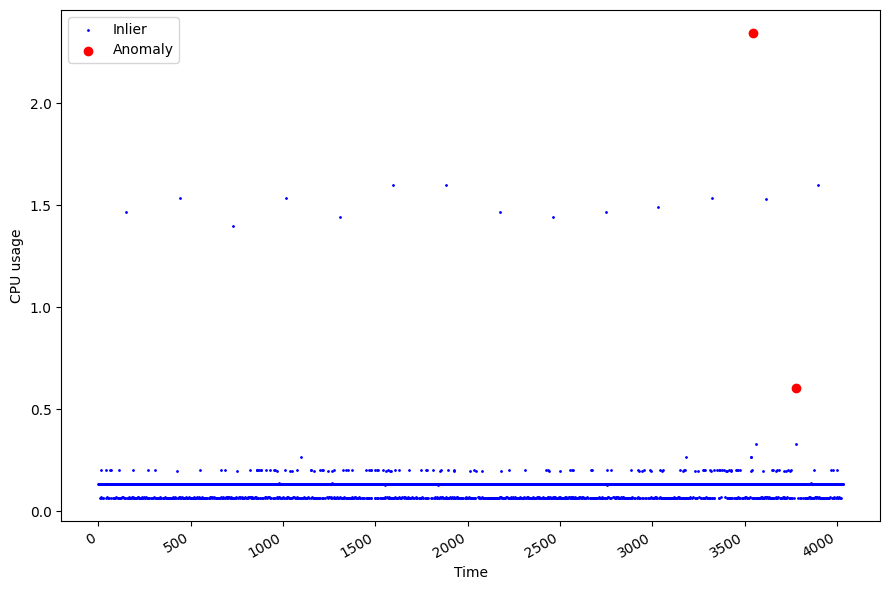

In [12]:
fig, ax = plt.subplots()

ax.scatter(inlier_df.index, inlier_df['value'], color='blue', s=1, label='Inlier')
ax.scatter(anomaly_df.index, anomaly_df['value'], color='red', label='Anomaly')
ax.set_xlabel('Time')
ax.set_ylabel('CPU usage')
ax.legend(loc=2)

plt.grid(False)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

**Observation:**  
The scatter plot displays CPU usage over time, with blue points representing normal (inlier) usage and red points indicating anomalies. The anomalies are significantly distinct from normal data points, suggesting deviations in CPU performance.

**Conclusion:**  
The detected anomalies likely indicate irregular CPU activity, possibly due to system overload, unusual application behavior, or external interference. Further investigation is required to determine the root cause and take corrective actions if necessary.

## Baseline: median absolute deviation (MAD) 

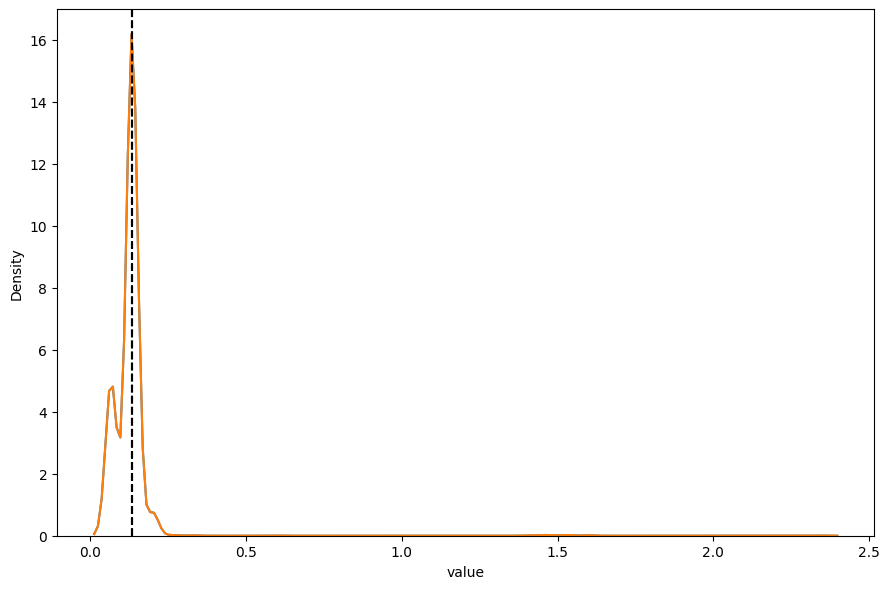

In [15]:
import seaborn as sns

sns.kdeplot(df['value']);
plt.grid(False)
plt.axvline(0.134, 0, 1, c='black', ls='--')
plt.tight_layout()
plt.show()

### **Observation:**  
The KDE plot illustrates the distribution of CPU usage values, showing a peak where most values are concentrated. The vertical dashed line at `0.134` may represent a key statistical threshold, such as the median CPU usage or a boundary for anomaly detection.

### **Conclusion:**  
If `0.134` represents a reference point like the median, it indicates that a significant portion of the data falls below this threshold. If it is an anomaly threshold, CPU usage values beyond this point may warrant further investigation. The KDE plot helps in understanding the normal operating range of CPU utilization.

In [16]:
from scipy.stats import median_abs_deviation

mad = median_abs_deviation(df['value'])
median = np.median(df['value'])

print(median)
print(mad)

def compute_robust_z_score(x):
    return .6745*(x-median)/mad

0.134
0.0020000000000000018


In [17]:
df['z-score'] = df['value'].apply(compute_robust_z_score)

df.head()

,timestamp,value,is_anomaly,z-score
0,2014-02-14 14:30:00,0.132,1,-0.6745
1,2014-02-14 14:35:00,0.134,1,0.0000
2,2014-02-14 14:40:00,0.134,1,0.0000
3,2014-02-14 14:45:00,0.134,1,0.0000
4,2014-02-14 14:50:00,0.134,1,0.0000


In [18]:
df['baseline'] = 1

df.loc[df['z-score'] >= 3.5, 'baseline'] = -1
df.loc[df['z-score'] <=-3.5, 'baseline'] = -1

### Evaluation 

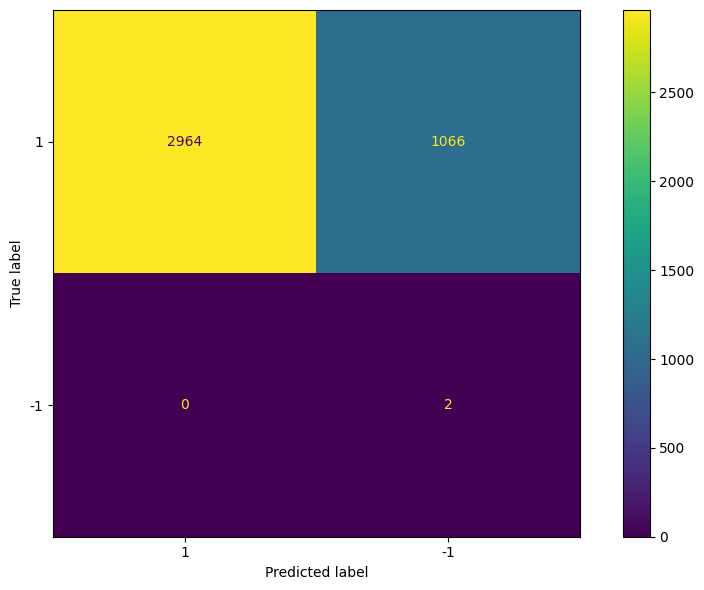

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(df['is_anomaly'], df['baseline'], labels=[1, -1])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

disp_cm.plot();

plt.grid(False)
plt.tight_layout()
plt.show(1)


### **Observation:**  
The confusion matrix visually represents the classification performance of the anomaly detection model. It compares actual anomalies with predicted ones, indicating true positives, false positives, true negatives, and false negatives. The matrix helps in assessing how well the model identifies anomalies versus normal CPU usage.  

### **Conclusion:**  
The model's effectiveness depends on the balance between correctly detected anomalies and misclassifications. A high number of false positives or false negatives suggests the need for tuning detection thresholds or improving the anomaly detection algorithm.

## Isolation forest 

In [23]:
import random
import numpy as np

class IsolationTree:
    def __init__(self, height_limit):
        self.height_limit = height_limit
        self.split_attribute = None
        self.split_value = None
        self.left = None
        self.right = None
        self.size = 0

    def fit(self, X, current_height=0):
        self.size = len(X)
        if current_height >= self.height_limit or self.size <= 1:
            return
        
        self.split_attribute = 0  # Since we have only one feature
        min_val, max_val = np.min(X), np.max(X)
        if min_val == max_val:
            return
        
        self.split_value = random.uniform(min_val, max_val)
        left_X = X[X < self.split_value]
        right_X = X[X >= self.split_value]
        
        self.left = IsolationTree(self.height_limit)
        self.left.fit(left_X, current_height + 1)
        
        self.right = IsolationTree(self.height_limit)
        self.right.fit(right_X, current_height + 1)
    
    def path_length(self, x, current_height=0):
        if self.left is None or self.right is None:
            return current_height + np.log2(self.size + 1)
        
        if x < self.split_value:
            return self.left.path_length(x, current_height + 1)
        else:
            return self.right.path_length(x, current_height + 1)


class IsolationForest:
    def __init__(self, n_trees=100, subsample_size=256):
        self.n_trees = n_trees
        self.subsample_size = subsample_size
        self.trees = []
        
    def fit(self, X):
        X = np.array(X).flatten()
        self.trees = []
        height_limit = np.ceil(np.log2(self.subsample_size))
        for _ in range(self.n_trees):
            sample = np.random.choice(X, size=min(self.subsample_size, len(X)), replace=False)
            tree = IsolationTree(height_limit)
            tree.fit(sample)
            self.trees.append(tree)
    
    def anomaly_score(self, X):
        X = np.array(X).flatten()
        scores = np.zeros(len(X))
        c = 2 * (np.log(len(X) - 1) + 0.5772156649) - (2 * (len(X) - 1) / len(X))
        for i, x in enumerate(X):
            avg_path_length = np.mean([tree.path_length(x) for tree in self.trees])
            scores[i] = 2 ** -(avg_path_length / c)
        return scores
    
    def predict(self, X, threshold=0.5):
        scores = self.anomaly_score(X)
        return np.where(scores > threshold, -1, 1)  # -1 for anomaly, 1 for normal

# Example Usage:
train = df[:3550]['value'].values.reshape(-1,1)
test = df[3550:]['value'].values.reshape(-1,1)



In [24]:
iso_forest = IsolationForest(n_trees=100, subsample_size=256)
iso_forest.fit(train)

anomaly_scores = iso_forest.anomaly_score(test)
predictions = iso_forest.predict(test)


In [27]:
anomaly_scores

array([0.48762528, 0.59235637, 0.53240002, 0.48762528, 0.53240002,
       0.53240002, 0.48762528, 0.48762528, 0.53240002, 0.48762528,
       0.59235637, 0.74881211, 0.53240002, 0.59235637, 0.48762528,
       0.48762528, 0.53240002, 0.59235637, 0.48762528, 0.63479545,
       0.53240002, 0.48762528, 0.59235637, 0.53240002, 0.59235637,
       0.48762528, 0.53240002, 0.59235637, 0.53240002, 0.48762528,
       0.59235637, 0.48762528, 0.53240002, 0.48762528, 0.59235637,
       0.48762528, 0.48762528, 0.48762528, 0.6551887 , 0.48762528,
       0.48762528, 0.59235637, 0.48762528, 0.48762528, 0.48762528,
       0.6551887 , 0.48762528, 0.70930075, 0.59235637, 0.48762528,
       0.59235637, 0.48762528, 0.48762528, 0.59235637, 0.53240002,
       0.53240002, 0.48762528, 0.63479545, 0.48762528, 0.6551887 ,
       0.48762528, 0.53240002, 0.6551887 , 0.48762528, 0.82234695,
       0.53240002, 0.59235637, 0.63479545, 0.48762528, 0.48762528,
       0.6551887 , 0.48762528, 0.53240002, 0.6551887 , 0.48762

In [31]:
preds_iso_forest = iso_forest.predict(test.flatten())
preds_iso_forest

array([ 1, -1, -1,  1, -1, -1,  1,  1, -1,  1, -1, -1, -1, -1,  1,  1, -1,
       -1,  1, -1, -1,  1, -1, -1, -1,  1, -1, -1, -1,  1, -1,  1, -1,  1,
       -1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1, -1,  1, -1, -1,  1, -1,
        1,  1, -1, -1, -1,  1, -1,  1, -1,  1, -1, -1,  1, -1, -1, -1, -1,
        1,  1, -1,  1, -1, -1,  1, -1,  1, -1,  1,  1, -1,  1, -1,  1, -1,
        1, -1,  1,  1, -1, -1,  1,  1,  1, -1, -1, -1, -1, -1, -1,  1,  1,
       -1, -1,  1, -1,  1, -1, -1,  1, -1, -1,  1,  1,  1, -1, -1,  1, -1,
        1, -1, -1, -1,  1, -1, -1, -1, -1,  1, -1,  1, -1, -1,  1,  1, -1,
        1, -1,  1,  1, -1,  1,  1, -1,  1, -1, -1,  1, -1, -1,  1, -1, -1,
       -1,  1,  1, -1, -1,  1,  1, -1,  1, -1,  1, -1, -1, -1, -1, -1,  1,
        1, -1,  1, -1, -1, -1, -1, -1,  1,  1,  1, -1,  1,  1, -1, -1,  1,
       -1, -1, -1,  1,  1,  1, -1,  1, -1,  1, -1, -1, -1, -1,  1, -1, -1,
        1, -1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1, -1, -1,  1,  1,  1,
       -1,  1, -1,  1,  1

### Evaluation 

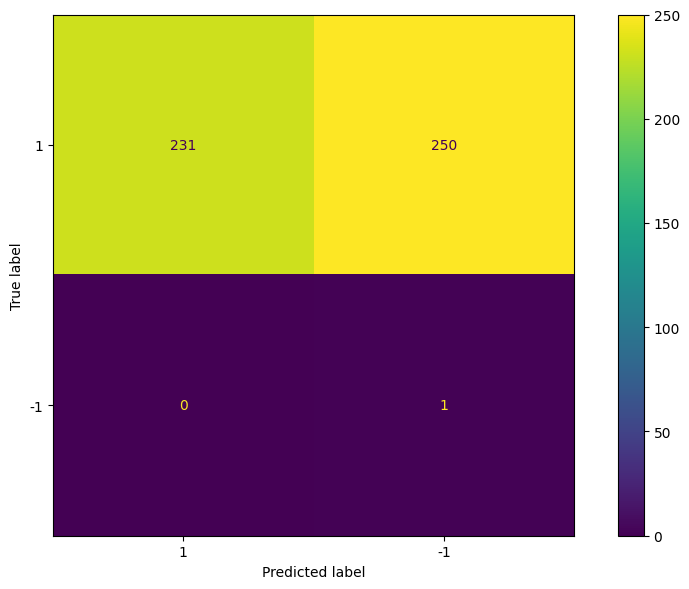

In [36]:
actual_labels = df[3550:]['is_anomaly'].values  # Assuming 'is_anomaly' column exists
cm = confusion_matrix(actual_labels, preds_iso_forest, labels=[1, -1])

# Plot Confusion Matrix
disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])
disp_cm.plot()
plt.grid(False)
plt.tight_layout()
plt.show()

### **Observation:**  
The confusion matrix visually represents how well the Isolation Forest model detects CPU usage anomalies. It shows the number of correctly identified anomalies (true positives), normal instances (true negatives), and misclassifications (false positives and false negatives). The distribution of these values helps assess the model’s reliability in identifying unusual CPU behavior.  

### **Conclusion:**  
The model's performance depends on the ratio of correct classifications to misclassifications. If the false positive or false negative rates are high, it may indicate the need for parameter tuning or an alternative detection approach. Analyzing the confusion matrix helps refine the model to improve anomaly detection accuracy.

## Local outlier factor (LOF) 

In [37]:
class LocalOutlierFactor:
    def __init__(self, contamination=0.1, n_neighbors=20):
        self.contamination = contamination
        self.n_neighbors = n_neighbors
        self.X_train = None
    
    def fit(self, X):
        self.X_train = np.array(X).flatten()
    
    def predict(self, X):
        X = np.array(X).flatten()
        n = len(self.X_train)
        distances = np.zeros((len(X), n))
        
        for i in range(len(X)):
            distances[i] = np.abs(self.X_train - X[i])
        
        k_distances = np.sort(distances, axis=1)[:, :self.n_neighbors]
        reachability_dist = np.maximum(k_distances, k_distances[:, -1][:, np.newaxis])
        local_reach_density = 1 / (np.mean(reachability_dist, axis=1) + 1e-10)
        lof_scores = np.mean(local_reach_density) / (local_reach_density + 1e-10)
        
        threshold = np.percentile(lof_scores, 100 * (1 - self.contamination))
        return np.where(lof_scores > threshold, -1, 1)  # -1 for anomaly, 1 for normal

In [38]:
lof = LocalOutlierFactor(contamination=1/len(train), n_neighbors=20)
lof.fit(train)

In [39]:
preds_lof = lof.predict(test.flatten())
preds_lof

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

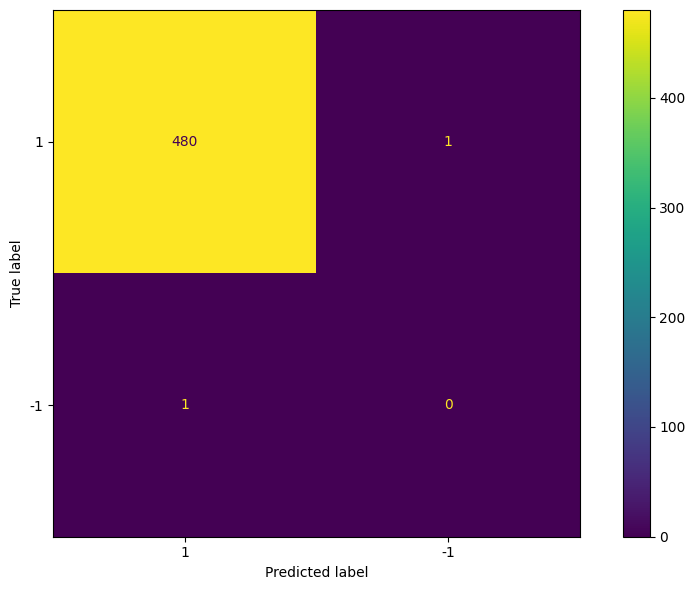

In [42]:
actual_labels = df[3550:]['is_anomaly'].values  
cm = confusion_matrix(actual_labels, preds_lof, labels=[1, -1])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])
disp_cm.plot()
plt.grid(False)
plt.tight_layout()
plt.show()


### **Observation:**  
The confusion matrix visually represents the classification results of the **LOF model** in detecting CPU usage anomalies. It shows the number of correct detections (true positives and true negatives) and misclassifications (false positives and false negatives). The distribution of these values provides insights into the model’s accuracy and error rate.  

### **Conclusion:**  
If the confusion matrix indicates a high number of false positives or false negatives, the **LOF model** may require hyperparameter tuning or an alternative detection approach. Comparing this confusion matrix with that of other models (e.g., Isolation Forest) helps determine which method is more effective in identifying CPU anomalies.